In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
## LEER CARPETA DE IMAGNES 
data_dir = Path("C:\Users\jchinome\OneDrive - Grupo Bancolombia\Auditoria\Automatizacion Querys\Capcha\ImagenesPrueba\Pruebas")

## TOMAR LA LISTA DE PAD DE IMAGENES
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
## TOMAR LA LISTA DE ETIQUETAS
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

In [9]:
print(images[50]+" "+labels[50])

C:\Users\jchinome\Documents\ImagenesPrueba\Pruebas\2n756.png 2n756


In [10]:
## TOMAMOS LA LISTA DE CARACTERES CONTENIDAS EN EL TOTAL DE ETIQUETEAS 

characters = set(char for label in labels for char in label)
characters = sorted(list(characters))


print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1498
Number of labels found:  1498
Number of unique characters:  23
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'm', 'n', 'p', 'r', 'w', 'x', 'y']


In [12]:
# Mapear caracteres a números enteros
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapear enteros a los caracteres originales
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [13]:
## TAMAÑO DE LOTE(DIVICION DEL LOTE TOTAL ) ENTRENAMIENTO Y VALIDACION 
batch_size = 16

## DEFINIR DIMENCIONES DE LA IMAGEN 

img_width = 204
img_height = 53

# Factor por el cual se reducirá la resolución de la imagen
# por los bloques convolucionales. estaremos usando dos
# bloques de convolución y cada bloque tendrá
# una capa de agrupación que reduce la muestra de las características por un factor de 2.
# Por lo tanto, el factor de reducción de muestreo total sería 4.

downsample_factor = 4

## Longitud máxima de cualquier captcha en el conjunto de datos

max_length = max([len(label) for label in labels])

In [14]:
print(max_length)

5


In [15]:

def encode_single_sample(img_path, label):

    # 1. Leer imagen 
    img = tf.io.read_file(img_path)
    # 2. Comvertir a escala de grises 
    img = tf.io.decode_png(img, channels=1) #[Altura , Ancho , Canales ] channels = 1 es ecala de grises 
    # 3. Convertir a float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Mantener la forma de la imagen siempre.
    img = tf.image.resize(img, [img_height, img_width]) #[Altura= 53 , Ancho=204 , Canales=1 ]
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2]) #[Altura= 204 , Ancho=53 , Canales=1 ]
    # 6. Mapear los caracteres de la etiquetas a numeros
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Retornar un diccionario con dos input de esta forma entrara al modelo
    return {"image": img, "label": label}

In [18]:
def split_data(images, labels, train_size=0.8, shuffle=True):
    # 1. Tomamos el tamaño total de los datos 
    size = len(images)
    # 2. Tomamos los indices con el valor de tamaño de los datos.
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    # 3. Tomamos el tamaño de los datos de entrenamiento 
    train_samples = int(size * train_size)

    # 4. Separamos lod datos entre los datos de entrenamiento y validacion 
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Aplicamos la funcion para tomar nuestros datos de validacion y entrenamiento 
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [21]:
# DATOS DE ENTRENAMIENTO 
# Convertimos los datos de entrenamiento a un objeto de tipo tf.data.dataset
# Mapeamos cada uno de nuestros datos pasandola por la funcion encode_simple_sample ademar de tomar los lotes de tamaño batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# DATOS DE VALIDACION 

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

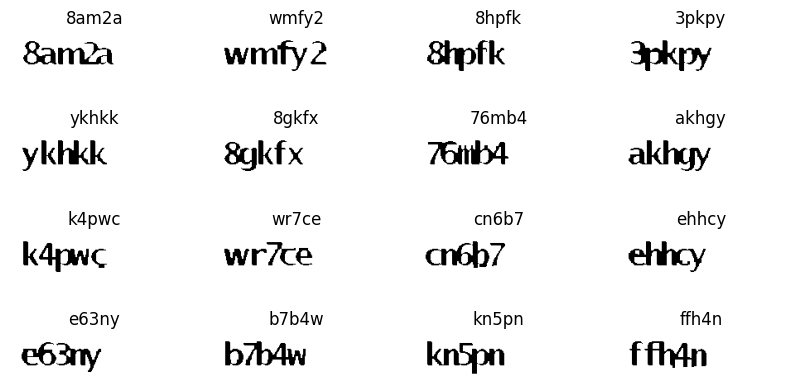

In [22]:
# VISUALIZAMOS UN LOTE DE LOS DATOS DE ENTRENAMIENTO.

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [23]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # ENTRADA DE IMAGEN AL MODELO 
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )

    # ENTRADA DE ETIQUETA AL MODELO

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # PRIMER BLOQUE CONVOLUCIONAL 

    x = layers.Conv2D(
        32,
        (3, 3),
        activation = "relu",                  
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)

    # REDUCE LA IMAGEN 
    # Tomando los valores maximos de cada uno de los valores en el mapa de caracteristicas 
    # (2,2) es el tamaño de la matriz que pasara por cada uno.

    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # SEGUNDO BLOQUE CONVOLUCIONAL
    # 64 , la dimensionalidad del espacio de salida (es decir, el número de filtros de salida en la convolución) tambien podriamos llamarlo los canales .
    # (3,3) tamaño de la matriz de convolucion que pasra por la imagen.
    # kernel_initializer="he_normal" , inicia con pesos aleatorios numeros positivos o negativos que seran partes de la matriz de convolucion.

    x = layers.Conv2D(
        64,                          
        (3, 3),
        activation="relu", 
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)

    # REDUCE LA IMAGEN 
    # Tomando los valores maximos de cada uno de los valores en el mapa de caracteristicas 
    # (2,2) es el tamaño de la matriz que pasara por cada uno.

    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Hemos usado dos max pool con tamaño de pool y strides 2.
    # Por lo tanto, los mapas de características remuestreados son 4 veces más pequeños. El número de
    # filtros en la última capa es 64. Remodelar en consecuencia antes de
    # pasar la salida a la parte RNN del modelo

    # FLATTEN 
    # Reducir una red de 2 dimenciones(matriz) a una sola dimencion(vector) de tamaño 64.

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)


    # RNNs
    # Entrenamiento bidireccional,la pediccion resultante de la prediccion en el tiempo t , sera tomado encuenta 
    # pueden depender de la entrada en el tiempo t+1 , usado abitualmente para aplicaciones de traduccion automatica.
    # Dimencionalidad de la read aumenta aun vector lineal de tamaño (128)
    # Dimencionalidad de la read disminuye a un vector lineal de tamaño (64)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # SALIDA DE LA RED 
    # Se reduce la red a solo 5 salida que es la longitud de nuetro capcha 
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)


    # Agregar  CTC layer para calcular la perdida CTC loss por cada paso.
    output = CTCLayer(name="ctc_loss")(labels, x) # labels = entrenamiento y x = prediccion final 

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 204, 53, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 204, 53, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 102, 26, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 102, 26, 64)  18496       ['pool1[0][0]']       

In [24]:
epochs = 100
early_stopping_patience = 10

# Añadir parada anticipada
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Entrenar el modelo 
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
75/75 [==============================] - 31s 293ms/step - loss: 21.1175 - val_loss: 17.4506
Epoch 2/100
75/75 [==============================] - 17s 230ms/step - loss: 17.4026 - val_loss: 17.4525
Epoch 3/100
75/75 [==============================] - 17s 228ms/step - loss: 17.3867 - val_loss: 17.4566
Epoch 4/100
75/75 [==============================] - 18s 239ms/step - loss: 17.3715 - val_loss: 17.4440
Epoch 5/100
75/75 [==============================] - 20s 267ms/step - loss: 17.3476 - val_loss: 17.3752
Epoch 6/100
75/75 [==============================] - 23s 302ms/step - loss: 17.1756 - val_loss: 16.9722
Epoch 7/100
75/75 [==============================] - 21s 277ms/step - loss: 15.8086 - val_loss: 13.8578
Epoch 8/100
75/75 [==============================] - 22s 297ms/step - loss: 11.0347 - val_loss: 6.4548
Epoch 9/100
75/75 [==============================] - 22s 291ms/step - loss: 5.0373 - val_loss: 1.9497
Epoch 10/100
75/75 [==============================] - 22s 292ms/ste

In [25]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 204, 53, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 204, 53, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 102, 26, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 102, 26, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 51, 13, 64)        0         
                                                                 
 reshape (Reshape)           (None, 51, 832)           0         
                                                                 
 dense1 (Dense)              (None, 51, 64)            53312 

In [26]:
def decode_batch_predictions(pred):
    # Rconocimiento de captcha por lotes .
    
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
  
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


1/1 [==============================] - 0s 97ms/step


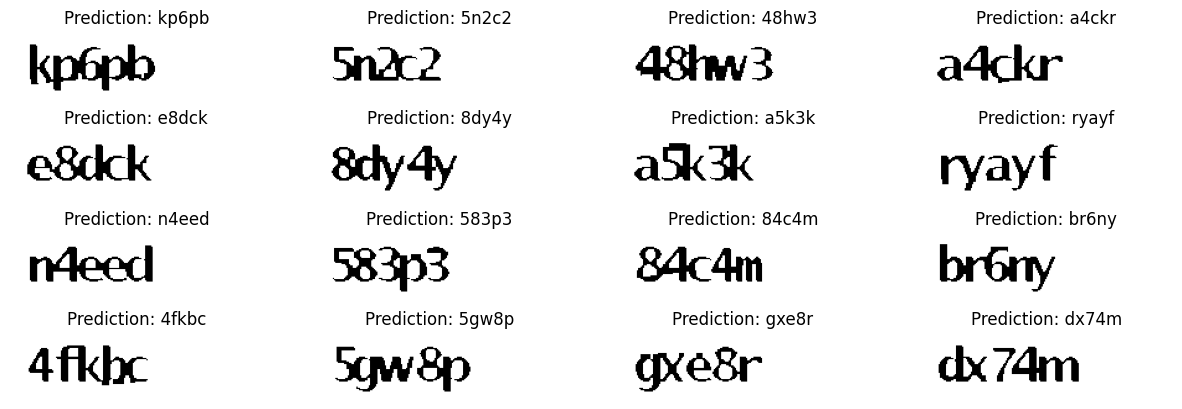

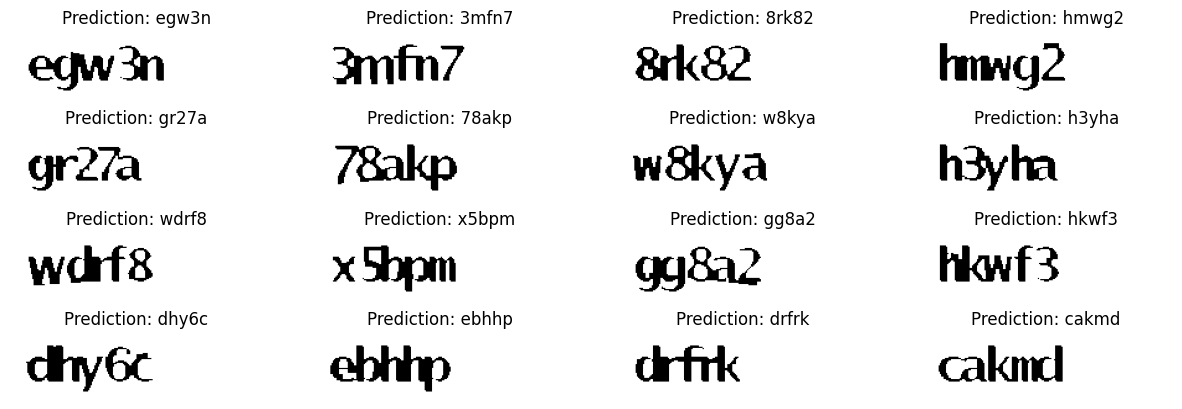

In [27]:
#  Mostrar resultados 
for batch in validation_dataset.take(2):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_textsv = decode_batch_predictions(preds)

    orig_texts_v = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts_v.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_textsv)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_textsv[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()



In [56]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(orig_texts_v, pred_textsv)

0.875

In [ ]:
# GUARDAR MODELO :

In [54]:
model.save(r'C:\Users\jchinome\OneDrive - Grupo Bancolombia\Auditoria\Automatizacion Querys\Capcha\Modelo\path_to_my_model2.h5')